In [1]:
import sklearn
import numpy as np
import umap
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns

import pald.PALD as PALD

np.random.seed(1234)

/Users/ryandewolfe/miniforge3/envs/PALD/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
we_vectors = np.load("news_vectors.npy")
targets = np.load("news_labels.npy")

## Custom Code

For the sake of PALD compute time cut down to 6 groups 100 docs/group

In [4]:
groups = [0, 2, 6, 9, 11, 14]  # Chosen to not be similar
docs_per_group = 100

keep = np.zeros_like(targets, dtype="bool")
for group in groups:
    this_group = targets == group
    random_selection = np.random.choice(
        this_group.nonzero()[0], docs_per_group, replace=False
    )
    for j in random_selection:
        keep[j] = True

labels = targets[keep]
data = we_vectors[keep, :]

print(labels.shape)
print(data.shape)

(600,)
(600, 160)


In [5]:
%%time
mapper = umap.UMAP()
data_map = mapper.fit_transform(data)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 3.47 s, sys: 130 ms, total: 3.6 s
Wall time: 2.98 s


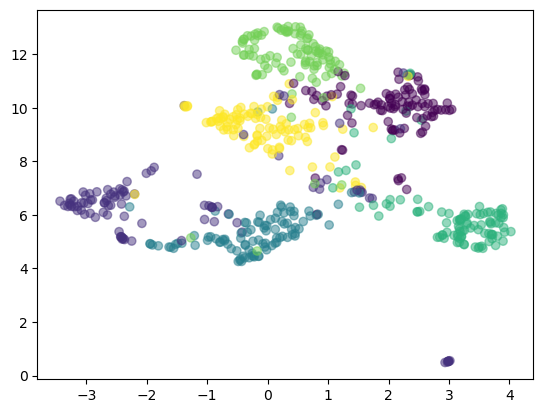

In [6]:
plt.scatter(data_map[:, 0], data_map[:, 1], c=labels, alpha=0.5)

# Predict in 2d with hdbscan and pald

HDBSCAN
PALD


179700it [00:06, 29209.93it/s].0 [00:06<00:00, 29617.20it/s]
100%|██████████| 179700/179700.0 [00:06<00:00, 29205.08it/s]


Text(0.5, 1.0, 'True Labels')

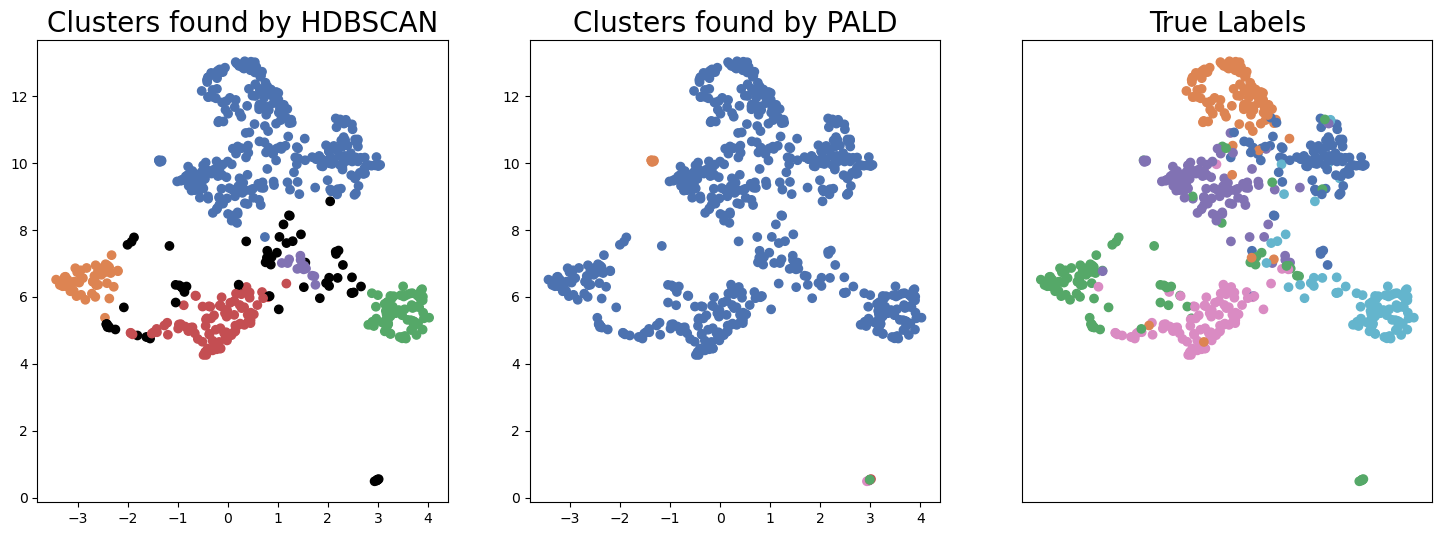

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
# HDBSCAN
print("HDBSCAN")
predict = hdbscan.HDBSCAN(min_cluster_size=15).fit_predict(data_map)
palette = sns.color_palette("deep", np.unique(predict).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in predict]
ax[0].scatter(data_map.T[0], data_map.T[1], c=colors)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
ax[0].set_title("Clusters found by HDBSCAN", fontsize=20)

# PALD
print("PALD")
distance_matrix = sklearn.metrics.pairwise.euclidean_distances(data_map)
pald = PALD.PALD()
predict = pald.fit_predict(distance_matrix)
palette = sns.color_palette("deep", np.unique(predict).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in predict]
ax[1].scatter(data_map.T[0], data_map.T[1], c=colors)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
ax[1].set_title("Clusters found by PALD", fontsize=20)

# Labels
palette = sns.color_palette("deep", np.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
ax[2].scatter(data_map.T[0], data_map.T[1], c=colors)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
ax[2].set_title("True Labels", fontsize=20)

(-0.1, 1.5)

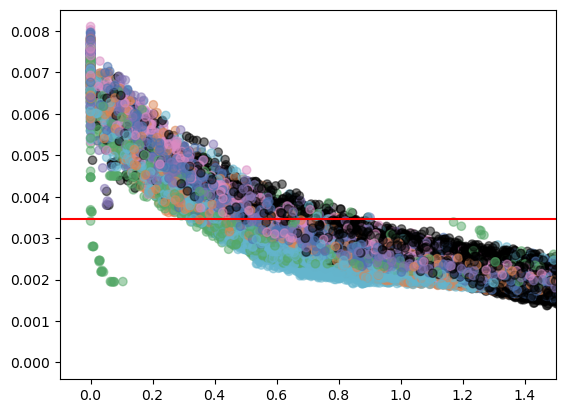

In [8]:
upper_triu = np.triu(np.ones_like(distance_matrix, dtype="bool"))
flat_upper_triu = upper_triu.flatten()

flat_dist = distance_matrix.flatten()[flat_upper_triu]
flat_cohesion = pald.pald.flatten()[flat_upper_triu]

palette = sns.color_palette("deep", np.unique(labels).max() + 1)
color_matrix = np.array(
    [
        [
            int(labels[i]) if labels[i] == labels[j] else -1
            for i in range(distance_matrix.shape[0])
        ]
        for j in range(distance_matrix.shape[1])
    ]
)
color = color_matrix.flatten()[flat_upper_triu]
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in color]

plt.scatter(flat_dist, flat_cohesion, alpha=0.5, color=colors)
plt.axhline(y=pald.threshhold, color="r", linestyle="-")

plt.xlim((-0.1, 1.5))

Text(0.5, 1.0, 'Clusters found by HDBSCAN')

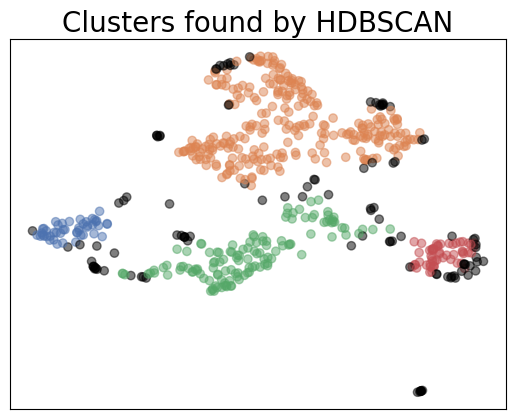

In [9]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15, gen_min_span_tree=True, metric="precomputed"
)
pald_dist = (1 - np.minimum(pald.pald, np.transpose(pald.pald))).astype("float64")
predict = clusterer.fit_predict(pald_dist)
palette = sns.color_palette("deep", np.unique(predict).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in predict]
plt.scatter(data_map.T[0], data_map.T[1], c=colors, alpha=0.5)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.title("Clusters found by HDBSCAN", fontsize=20)

# Predict High plot low

HDBSCAN
PALD


179700it [00:06, 29548.95it/s].0 [00:06<00:00, 29488.04it/s]
100%|██████████| 179700/179700.0 [00:06<00:00, 29542.96it/s]


Text(0.5, 1.0, 'True Labels')

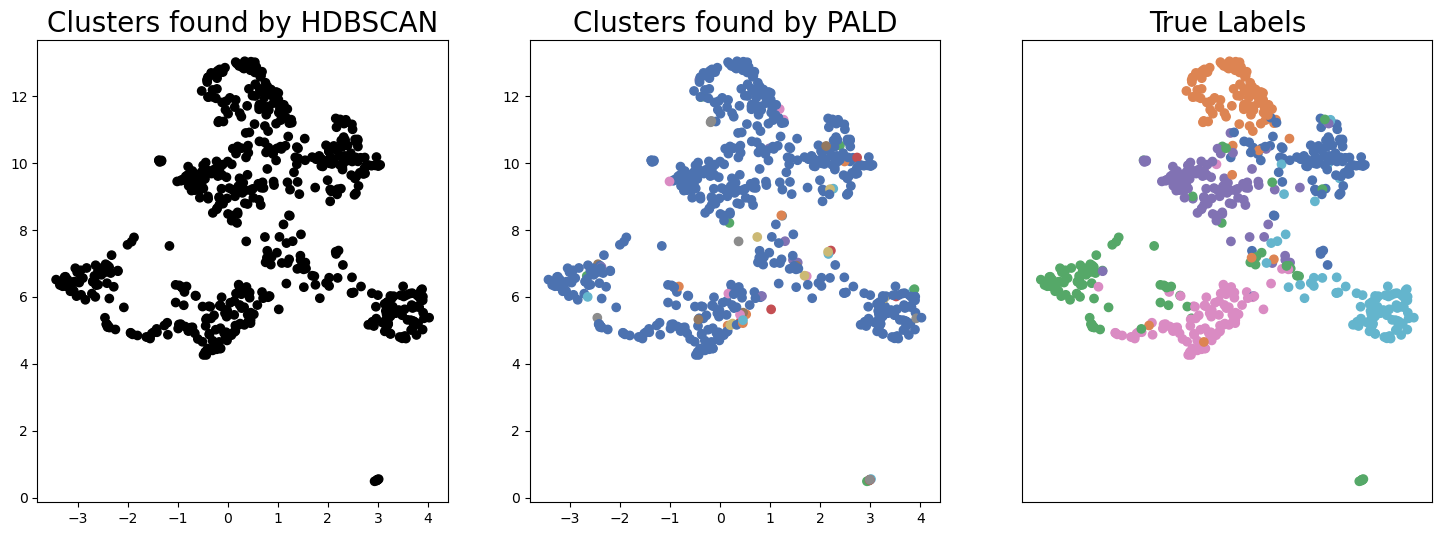

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
# HDBSCAN
print("HDBSCAN")
predict = hdbscan.HDBSCAN(min_cluster_size=15).fit_predict(data)
palette = sns.color_palette("deep", np.unique(predict).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in predict]
ax[0].scatter(data_map.T[0], data_map.T[1], c=colors)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
ax[0].set_title("Clusters found by HDBSCAN", fontsize=20)

# PALD
print("PALD")
distance_matrix = sklearn.metrics.pairwise.euclidean_distances(data)
pald = PALD.PALD()
predict = pald.fit_predict(distance_matrix)
palette = sns.color_palette("deep", np.unique(predict).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in predict]
ax[1].scatter(data_map.T[0], data_map.T[1], c=colors)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
ax[1].set_title("Clusters found by PALD", fontsize=20)

# Labels
palette = sns.color_palette("deep", np.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
ax[2].scatter(data_map.T[0], data_map.T[1], c=colors)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
ax[2].set_title("True Labels", fontsize=20)

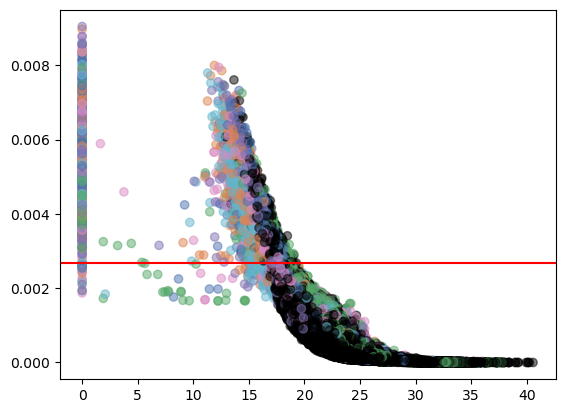

In [11]:
upper_triu = np.triu(np.ones_like(distance_matrix, dtype="bool"))
flat_upper_triu = upper_triu.flatten()

flat_dist = distance_matrix.flatten()[flat_upper_triu]
flat_cohesion = pald.pald.flatten()[flat_upper_triu]

palette = sns.color_palette("deep", np.unique(labels).max() + 1)
color_matrix = np.array(
    [
        [
            int(labels[i]) if labels[i] == labels[j] else -1
            for i in range(distance_matrix.shape[0])
        ]
        for j in range(distance_matrix.shape[1])
    ]
)
color = color_matrix.flatten()[flat_upper_triu]
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in color]

plt.scatter(flat_dist, flat_cohesion, alpha=0.5, color=colors)
plt.axhline(y=pald.threshhold, color="r", linestyle="-")

# plt.xlim((-0.1, 1.5))

Text(0.5, 1.0, 'Clusters found by HDBSCAN')

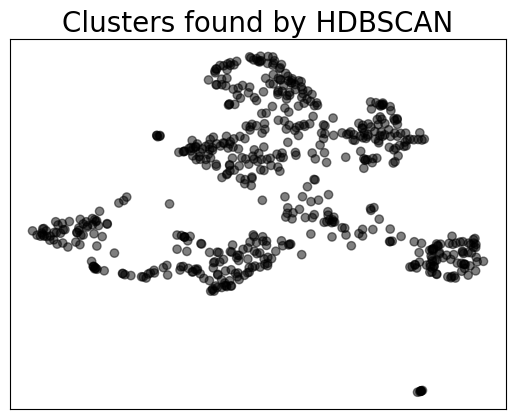

In [12]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    cluster_selection_method="leaf",
    gen_min_span_tree=True,
    metric="precomputed",
)
pald_dist = (1 - np.minimum(pald.pald, np.transpose(pald.pald))).astype("float64")
predict = clusterer.fit_predict(pald_dist)
palette = sns.color_palette("deep", np.unique(predict).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in predict]
plt.scatter(data_map.T[0], data_map.T[1], c=colors, alpha=0.5)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.title("Clusters found by HDBSCAN", fontsize=20)

## Cohesion vs nn

In [13]:
rows_sorted_nn = np.empty_like(pald.pald)
for i in range(pald.pald.shape[0]):
    sort_perm = np.argsort(distance_matrix[i, :])
    rows_sorted_nn[i, :] = pald.pald[i, :][sort_perm]

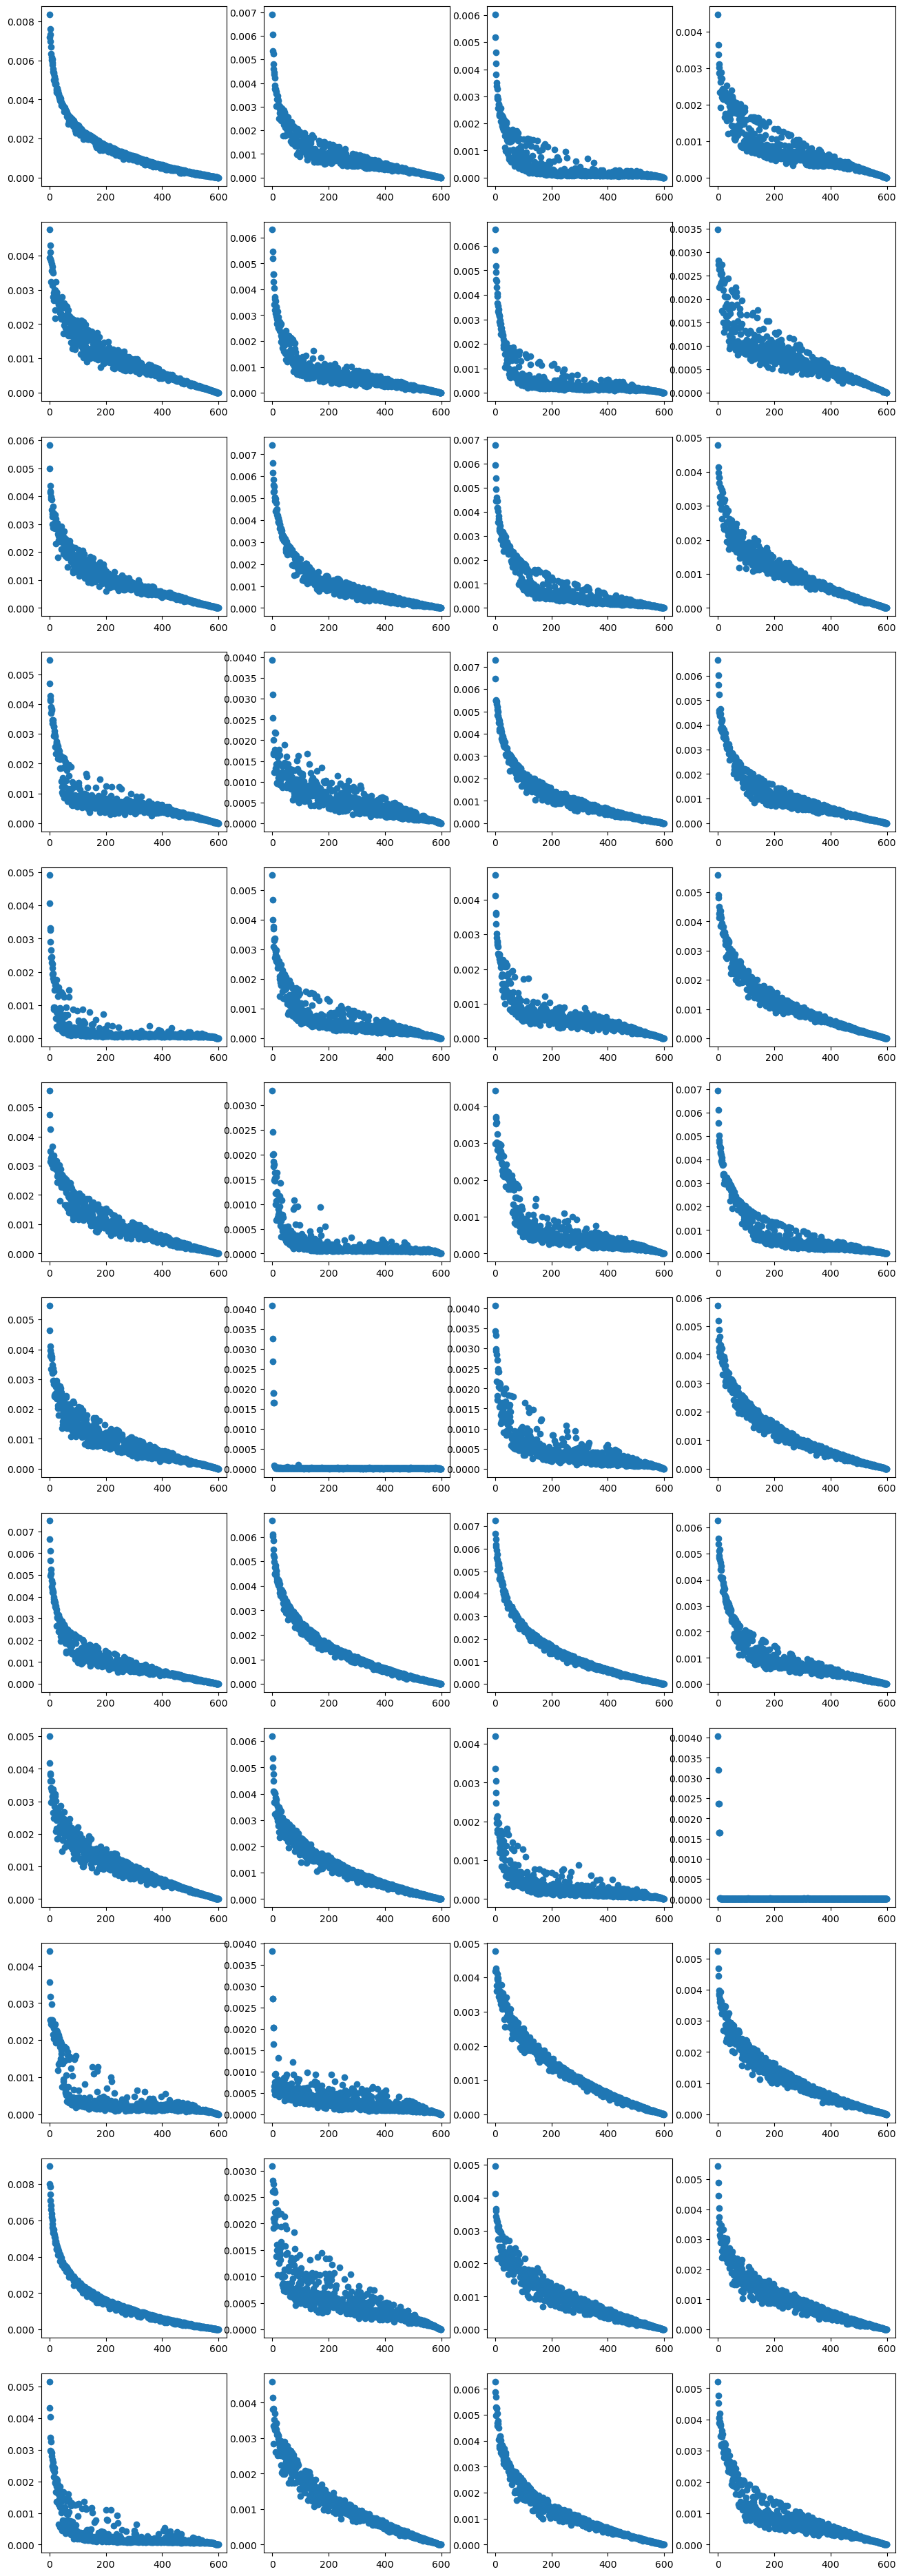

In [14]:
fig, ax = plt.subplots(4 * 3, 4, figsize=(16, 16 * 3))

rows = np.random.choice(range(rows_sorted_nn.shape[0]), size=4 * 4 * 3, replace=False)
count = 0
for i in range(4):
    for j in range(4 * 3):
        ax[j, i].scatter(range(rows_sorted_nn.shape[1]), rows_sorted_nn[rows[count]])
        count += 1